# Imports divers

In [1]:
try: # are we in a module?
    __file__
except NameError:
    # if not, change path to root
    import os
    try: CWD
    except NameError: CWD = os.getcwd()
    os.chdir(os.path.join(CWD, ".."))

In [2]:
import notebook_autoloader

In [3]:
from Constants import *
from Utils import *

# Députés par électeur

Nous définissons ici deux fonctions permettant de représenter le résultat d'une élection législative en termes de nombre d'élus et de représentativité (indépendamment des aspects géographiques).

## Coordonnées cartésiennes

Pour avoir une idée de la prime majoritaire, on montre le nombre d'électeurs par députés.
Horizontalement, les sièges à l'assemblée, par nuance dans un ordre ~gauche/droite.
Verticalement, le nombre moyen d'électeur au premier tour par député (par nuance).
L'aire de chaque rectangle correspond donc au nombre d'électeurs du premier tour pour chaque nuance.

In [4]:
from seagull import scenegraph as sg
from math import log

def representativity_graph_cartesian(winners, votes, M=None, ratio=0.5, k=None):
    W = 1000
    # W = horizontal scale (= width of the graph from left to right)
    H = int(1000*ratio)
    # H = vertical scale (= height of the highest bar)
    scene = sg.Group(transform=[sg.Scale(1, -1)])

    x = 0

    N = sum(winners)
    V = sum(votes)/N
    if M is None:
        M = max(v / n if n != 0 else 0 for v, n in zip(votes, winners))
    if k is not None:
        M = k*V

    for i, nuance in enumerate(NUANCES):
        n = winners[i]
        if n == 0:
            continue
        v = votes[i]/n
        scene.children += [
            sg.Rectangle(
                x=x, width=n*W/N, y=0, height=v*H/M,
                title="%s (×%.2f)" % (nuance, v/V),
                fill=sg.Color(*rgb(COLORS[nuance]))
            )
        ]
        x += n*W/N
    scene.children += [
        sg.Line(
            x2=x, y1=V*2**k*H/M, y2=V*2**k*H/M,
            stroke_width=1 if k == 0 else .5,
            stroke=sg.Color.black
        )
        for k in range(int(log(M/V, 2)) - 4, int(log(M/V, 2)) + 1)
    ] + [
        sg.Text(
            "%i" % (V*2**k,),
            text_anchor="end",
            transform=[sg.Translate(-5, V*2**k*H/M-5), sg.Scale(1, -1)]
        )
        for k in range(int(log(M/V, 2)) - 4, int(log(M/V, 2)) + 1)
    ]

    return scene

## Coordonnées polaires

Un diagramme en "assemblée".
Le rayon n'est pas linéaire avec le nombre d'électeurs par siège car on souhaite que les aires restent proportionnelles au nombre d'électeurs du premier tour par nuance.
Le rayon croît donc avec :

$\frac{V}{V_1} (R_1^2 - R_0^2) = (R^2 - R_0^2)$ soit :
$R = \sqrt{\frac{V}{V_1} (R_1^2-R_0^2) + R_0^2}$

In [5]:
from math import cos, sin, pi, sqrt

def representativity_graph_polar(winners, votes, k=None):
    R0, R1 = 100, 600

    N = sum(winners)
    V = sum(votes)/N
    if k is not None:
        M = k*V
        bg = [sg.Rectangle(x=-k*3*R1, width=2*3*k*R1, y=-40, height=3*k*R1+40, fill=None, stroke=sg.Color.black)]
        ks = range(-2, 3)
        R_max = 3*k*R1
    else:
        M = max(v / n if n != 0 else 0 for v, n in zip(votes, winners))
        bg = []
        ks = range(int(log(M/V, 2)) - 4, int(log(M/V, 2)) + 1)
        R_max = float('inf')
        
    V0, V1 = 0, M
    
    scene = sg.Group(transform=[sg.Scale(1, -1)], children=bg)
    a = pi
    for i, nuance in enumerate(NUANCES):
        n = winners[i]
        if n == 0:
            continue
        v = votes[i]/n
        r = sqrt(v/V1*(R1**2-R0**2) + R0**2)
        if r > R_max:
            continue
        da = pi*n/N
        ca0, sa0 = cos(a), sin(a)
        a -= da
        ca1, sa1 = cos(a), sin(a)
        scene.children += [
            sg.Path(
                fill=sg.Color(*rgb(COLORS[nuance])),
                title="%s (×%.2f)" % (nuance, v/V),
                d=[
                    "M", (r*ca0, r*sa0),
                    "A", (r, r), 0, (False, False), (r*ca1, r*sa1),
                    "L", (R0*ca1, R0*sa1),
                    "A", (R0, R0), 0, (False, True), (R0*ca0, R0*sa0),
                    "Z"
                ]
            )
        ]

    marks = sg.Group()
    for k in ks:
        vk = V*2**k
        r = sqrt(vk/V1*(R1**2-R0**2) + R0**2)
        ca, sa = -1, 0
        marks.children += [
            sg.Text(
                "%i" % (vk,),
                text_anchor="end",
                transform=[sg.Translate(-r, -20), sg.Scale(1, -1)]
            ),
        ]
    
        marks.children += [
            sg.Path(
                stroke=sg.Color.black,
                fill=None,
                stroke_width=3 if k == 0 else 1,
                d=[
                    "M", (r*ca, r*sa),
                    "A", (r, r), 0, (False, False), (r, 0),
                ]
            ),
            sg.Text(
                "%i" % (vk,),
                transform=[sg.Translate(r, -20), sg.Scale(1, -1)]
            ),
        ]

    scene.children.append(marks)
    
    return scene

# Test avec les données réelles

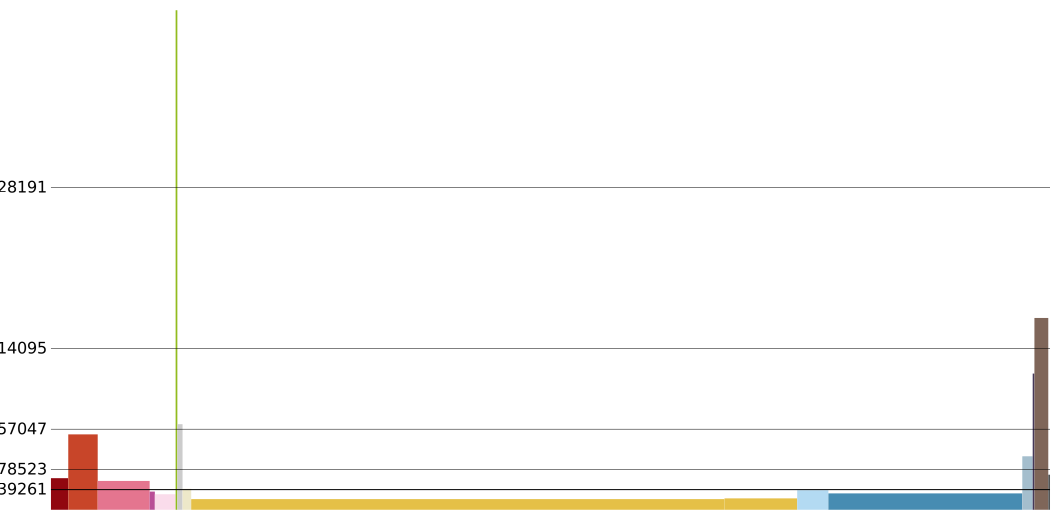

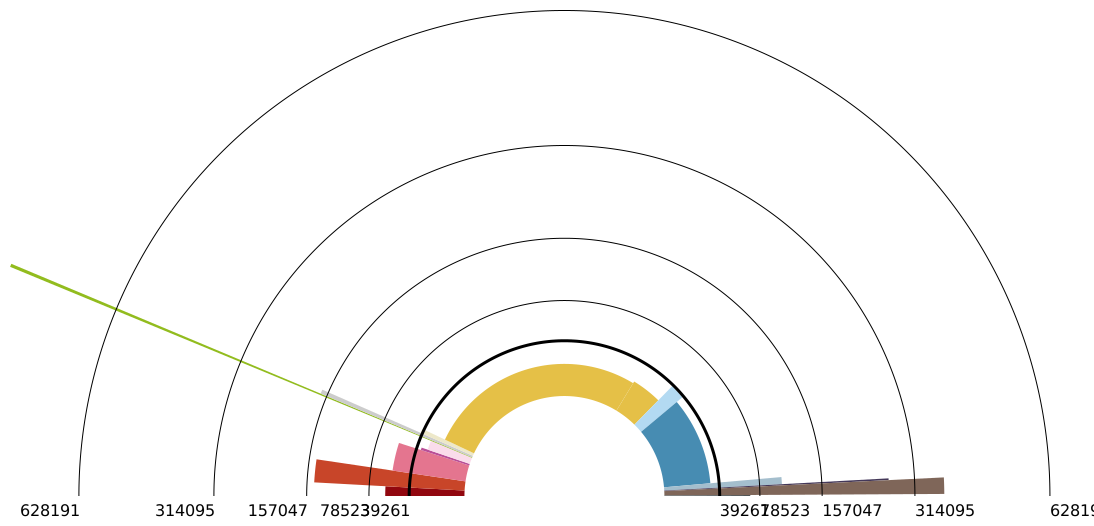

In [6]:
def test_representativity_graph():
    from data.DataLoader import circonscriptions
    from IPython.display import SVG

    from seagull.xml.serializer import serialize
    
    votes = [sum(c['t1'][n + 6] for c in circonscriptions.values()) for n in range(len(NUANCES))]
    winners = RESULTATS_OFFICIELS    
    
    return [
        SVG(serialize(graph(winners, votes), margin=10))
        for graph in [
            representativity_graph_cartesian,
            representativity_graph_polar,
        ]
    ]

try:
    __file__
except NameError:
    from IPython.display import display
    display(*test_representativity_graph())

0.6741463767480518


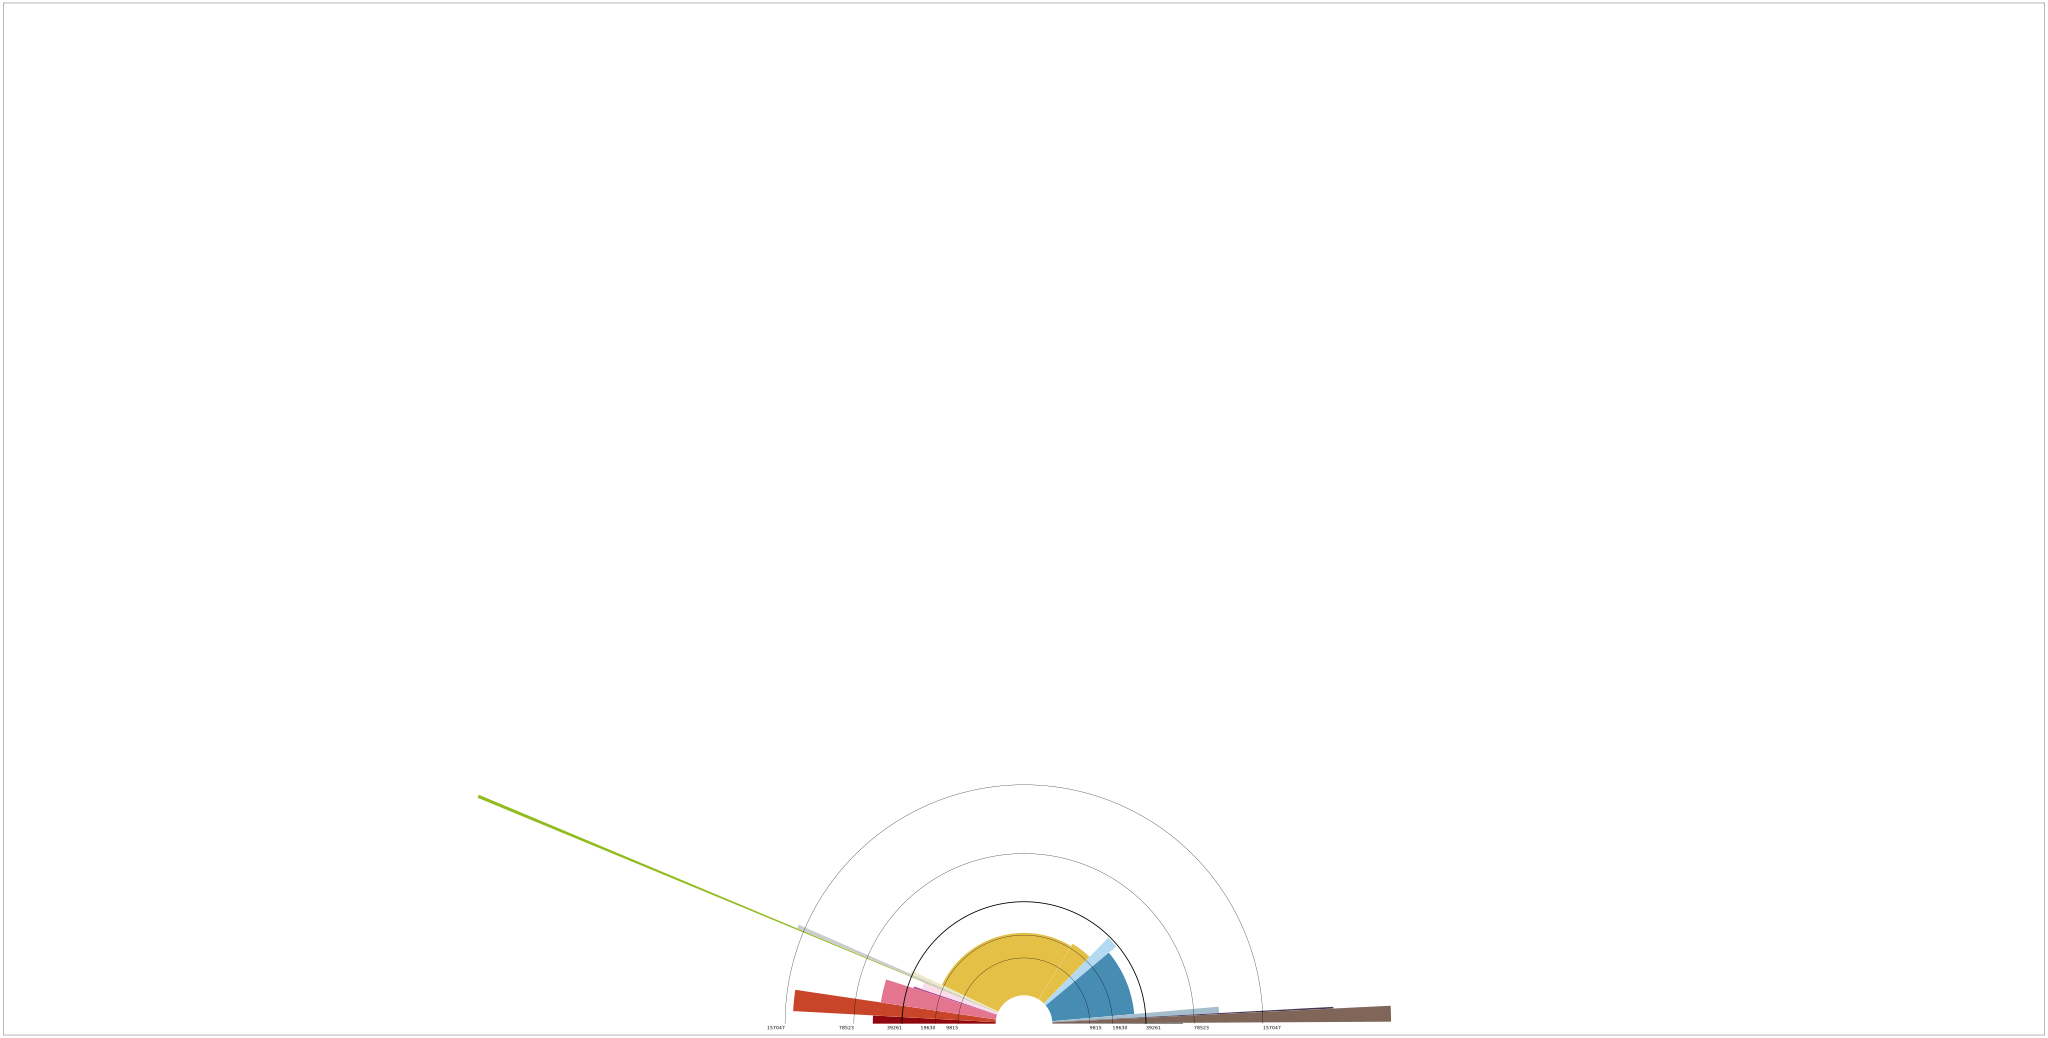

0.9913033546282


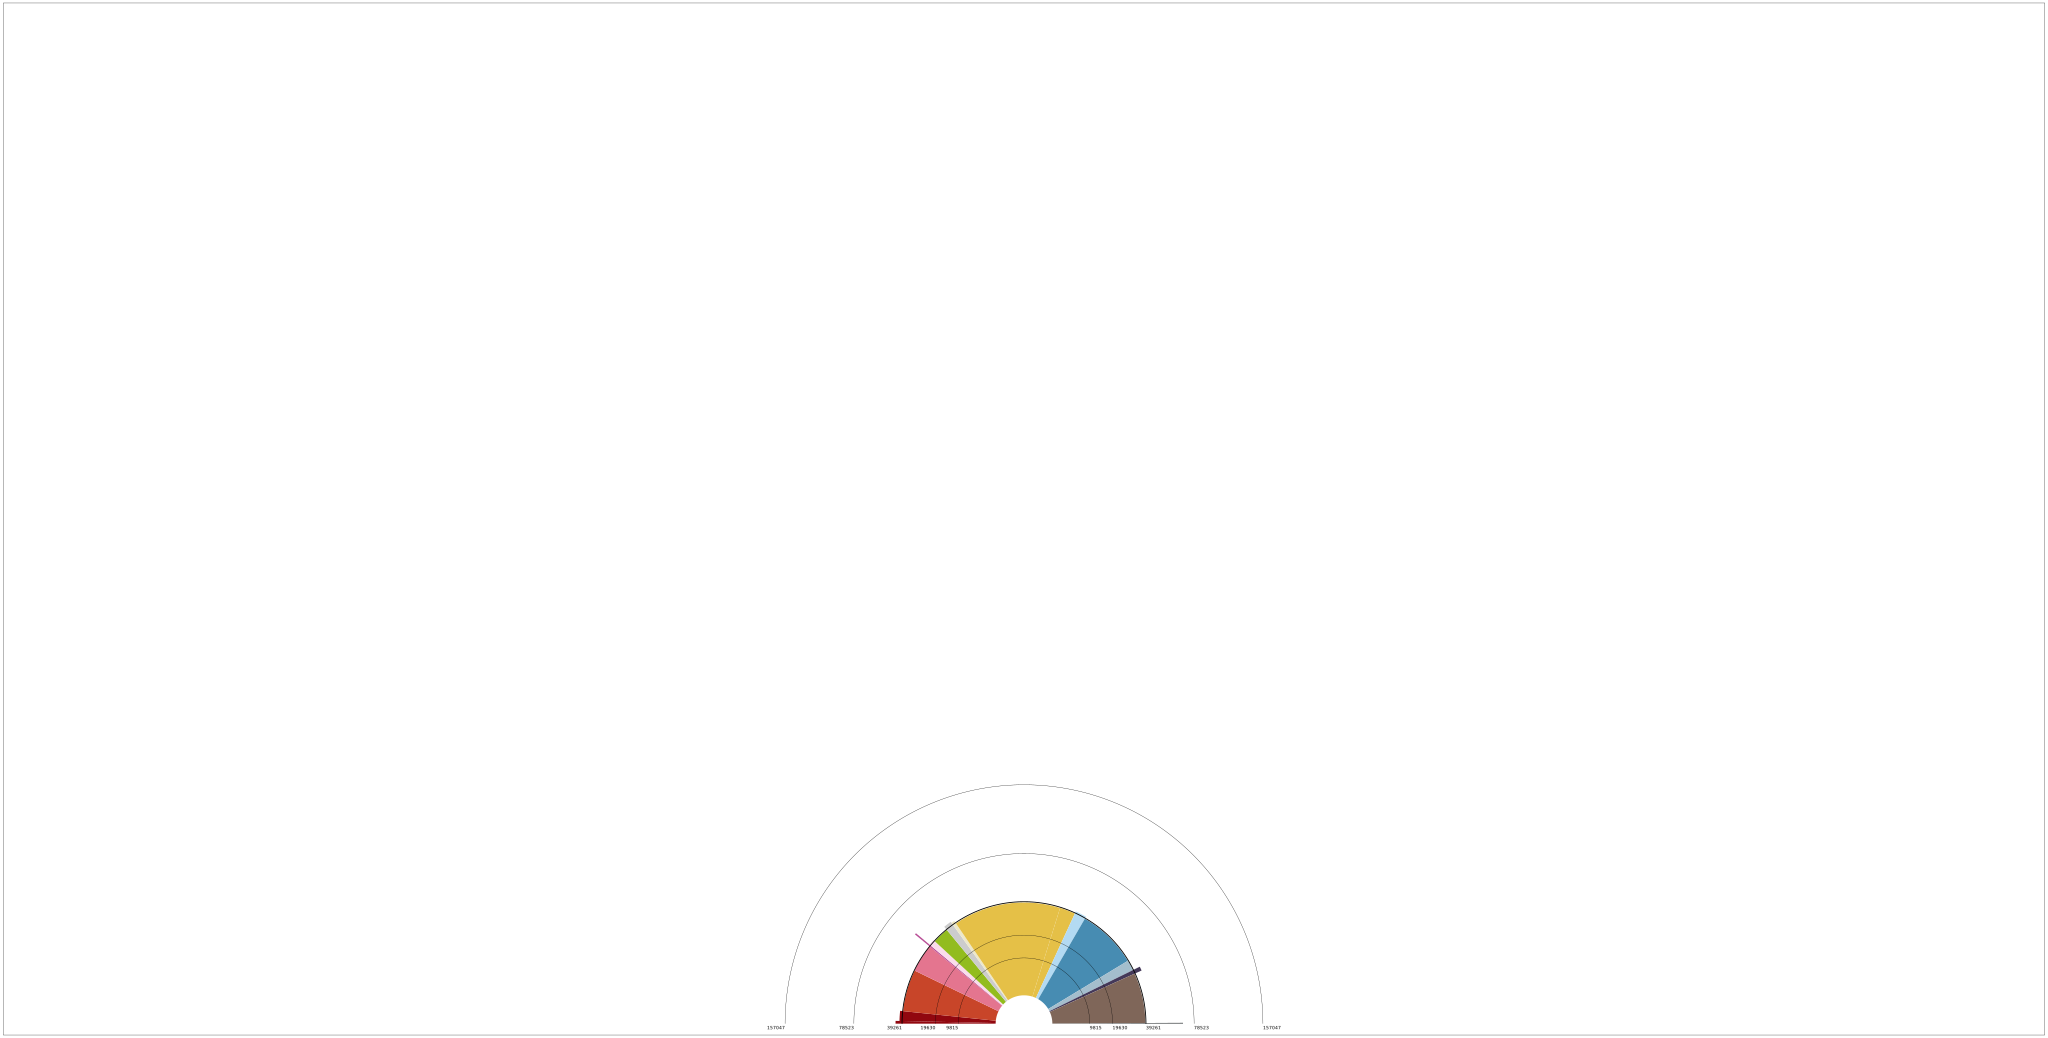

In [7]:
def sample_graphs():
    from data.DataLoader import circonscriptions
    from rules.Proportional import dhondt
    from simulations.Metrics import quality
    from IPython.display import display, SVG

    from seagull.xml.serializer import serialize
    
    votes = [sum(c['t1'][n + 6] for c in circonscriptions.values()) for n in range(len(NUANCES))]
    winners_off  = RESULTATS_OFFICIELS
    winners_prop = dhondt(votes, [0 for _ in winners_off], sum(winners_off))
    for winners, name in zip([winners_off, winners_prop], ["maj", "prop"]):
        print(quality(winners, votes))
        svg = serialize(representativity_graph_polar(winners, votes, k=2), margin=10)
        with open('polar-577-%s.svg' % name, "w") as svg_file:
            svg_file.write(svg)
        display(
            SVG(svg),
        )

try:
    __file__
except NameError:
    sample_graphs()